In [2]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

In [115]:
# testing tick data i found - IVE (S&P 500 Value Index)
df = pd.read_csv("../../Data/IVE_tickbidask.txt", header=None, names=['date', 'time', 'price', 'bid', 'ask', 'volume'])

df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.drop(['date', 'time'], axis=1).set_index('datetime')

print(df.describe())

              price           bid           ask        volume  \
count  1.208708e+07  1.208708e+07  1.208708e+07  1.208708e+07   
mean   1.126140e+02  1.126031e+02  1.126235e+02  2.432015e+02   
min    1.100000e-01  0.000000e+00  0.000000e+00  0.000000e+00   
25%    8.919000e+01  8.918000e+01  8.920000e+01  1.000000e+02   
50%    1.076450e+02  1.076400e+02  1.076500e+02  1.000000e+02   
75%    1.413300e+02  1.413200e+02  1.413400e+02  2.000000e+02   
max    2.118300e+02  2.116600e+02  6.048500e+02  5.157948e+06   
std    3.625035e+01  3.624854e+01  3.625447e+01  4.544144e+03   

                            datetime  
count                       12087076  
mean   2018-05-09 15:25:33.436868608  
min              2009-09-28 09:30:00  
25%              2015-08-21 15:57:40  
50%       2018-10-11 14:46:11.500000  
75%              2021-07-06 12:18:37  
max              2025-10-29 16:41:00  
std                              NaN  


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12087076 entries, 0 to 12087075
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      object        
 1   time      object        
 2   price     float64       
 3   bid       float64       
 4   ask       float64       
 5   volume    int64         
 6   datetime  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 645.5+ MB
None


### Excercise 2.2: 
On a series of E-mini S&P 500 futures tick data:

**(a)** Form tick, volume, and dollar bars. Use the ETF Trick to deal with the roll.

### ---------------Tick Bar-------------------

In [78]:
def tick_bar(threshold, df):
    agg_dict = {
        'price': ['first', 'max', 'min', 'last'],
        'volume': 'sum',
        'datetime': 'last'
    }

    tick_bar = df.groupby(df.index // threshold).agg(agg_dict)
    tick_bar.columns = ['open', 'high', 'low', 'close', 'volume', 'datetime']
    tick_bar.set_index('datetime', inplace=True)
    
    return tick_bar

tick_bars = tick_bar(45, df)
tick_bars

,open,high,low,close,volume
datetime,,,,,
2009-09-28 09:40:44,50.790,50.850,50.710,50.7833,9744
2009-09-28 09:47:20,50.800,51.070,50.800,51.0600,18300
2009-09-28 09:52:32,51.060,51.148,51.060,51.1300,9524
2009-09-28 09:54:34,51.130,51.150,51.101,51.1300,16151
2009-09-28 09:54:43,51.130,51.140,51.129,51.1400,19305
...,...,...,...,...,...
2025-10-29 15:58:37,209.100,209.200,209.070,209.1500,7487
2025-10-29 15:59:46,209.140,209.175,209.080,209.1100,9733
2025-10-29 15:59:59,209.125,209.320,209.125,209.3200,9319


#### ------------------Volume Bar------------------

In [69]:
def volume_bar(threshold, df):
    agg_dict = {
        'price': ['first', 'max', 'min', 'last'],
        'volume': 'sum',
        'datetime': 'last'
    }

    volume_bar = df.groupby(df['volume'].cumsum() // threshold).agg(agg_dict)
    volume_bar.columns = ['open', 'high', 'low', 'close', 'volume', 'datetime']
    volume_bar.set_index('datetime', inplace=True)

    return volume_bar

volume_bars = volume_bar(100000, df)
volume_bars

,open,high,low,close,volume
datetime,,,,,
2009-09-28 10:02:48,50.7900,51.2600,50.7100,51.2500,99914
2009-09-28 10:26:56,51.2500,51.2900,51.1873,51.2300,99991
2009-09-28 11:22:58,51.2300,51.3800,51.2300,51.3400,99887
2009-09-28 12:04:34,51.3581,51.4400,51.3200,51.4400,100162
2009-09-28 13:57:44,51.4400,51.6000,51.4104,51.4900,100015
...,...,...,...,...,...
2025-10-29 14:14:02,210.0600,210.4105,209.9300,210.0300,96157
2025-10-29 14:49:14,210.0100,210.1900,208.6500,209.0300,103850
2025-10-29 15:08:22,209.0400,209.5200,208.9400,209.3900,99900


#### ------------------Dollar Bar------------------

In [80]:
def dollar_bar(threshold, df):
    agg_dict = {
        'price': ['first', 'max', 'min', 'last'],
        'volume': 'sum',
        'datetime': 'last'
    }

    dollar_bar = df.groupby((df['price'] * df['volume']).cumsum() // threshold).agg(agg_dict)
    dollar_bar.columns = ['open', 'high', 'low', 'close', 'volume', 'datetime']
    dollar_bar.set_index('datetime', inplace=True)

    return dollar_bar

dollar_bars = dollar_bar(1000000, df)
dollar_bars

,open,high,low,close,volume
datetime,,,,,
2009-09-28 09:46:34,50.790,51.070,50.710,51.0700,19144
2009-09-28 09:52:41,51.070,51.148,51.050,51.1246,19924
2009-09-28 09:54:36,51.130,51.150,51.129,51.1290,19651
2009-09-28 09:54:43,51.129,51.140,51.129,51.1400,18657
2009-09-28 10:01:06,51.140,51.260,51.080,51.2600,20434
...,...,...,...,...,...
2025-10-29 15:59:59,209.310,209.320,209.300,209.3200,4652
2025-10-29 15:59:59,209.320,209.320,209.320,209.3200,4900
2025-10-29 15:59:59,209.320,209.340,209.310,209.3400,4800


**(b)** Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot a time series of that bar count. What bar type produces the most stable weekly count? Why?

In [91]:
tick_bars_weekly = tick_bars['close'].resample('W').count()
volume_bars_weekly = volume_bars['close'].resample('W').count()
dollar_bars_weekly = dollar_bars['close'].resample('W').count()

In [92]:
tick_bars_weekly.std(), volume_bars_weekly.std(), dollar_bars_weekly.std()

(np.float64(218.93001077260024),
 np.float64(20.0889007972155),
 np.float64(216.9933822231834))

In [93]:
import seaborn as sns

<Axes: xlabel='datetime'>

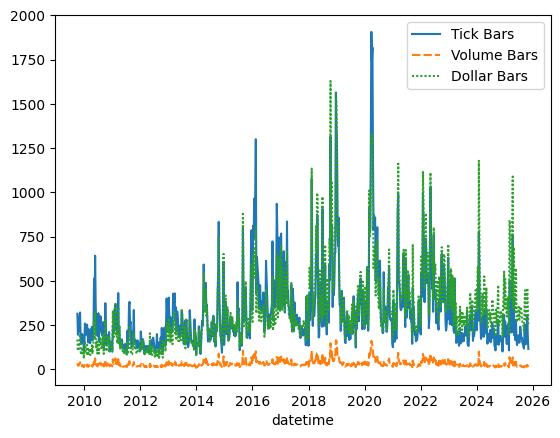

In [99]:
plot_data = pd.concat([tick_bars_weekly, volume_bars_weekly, dollar_bars_weekly], axis=1)
plot_data.columns = ['Tick Bars', 'Volume Bars', 'Dollar Bars']
sns.lineplot(data=plot_data)


In [102]:
print("Coefficient of variation:")
print(f"Tick bars: {tick_bars_weekly.std() / tick_bars_weekly.mean()}")
print(f"Volume bars: {volume_bars_weekly.std() / volume_bars_weekly.mean()}")
print(f"Dollar bars: {dollar_bars_weekly.std() / dollar_bars_weekly.mean()}")


Coefficient of variation:
Tick bars: 0.6846606095598103
Volume bars: 0.6098325564548089
Dollar bars: 0.6519604157231912


# Bar Stability Analysis: Tick, Volume vs. Dollar Bars

### Objective
Compare the stability of weekly bar production counts for three sampling methods: Tick Bars, Volume Bars, and Dollar Bars, based on S&P 500 data (2009–2025).

### Methodology
1.  **Data:** Tick data for the S&P 500 covering a period of strong bull market (price increase from ~$50 to ~$200).
2.  **Bar Generation (Fixed Thresholds):**
    * **Tick Bars:** every N transactions.
    * **Volume Bars:** every N shares traded.
    * **Dollar Bars:** every N dollars exchanged.
3.  **Stability Metric:** Coefficient of Variation (CV).
    * $CV = \frac{\sigma}{\mu}$ (lower value indicates more stable sampling).

### Experiment Results

| Bar Type | CV (Result) | Interpretation |
| :--- | :--- | :--- |
| **Volume Bars** | **~0.61** | Lowest variability in this study (unexpected). |
| **Dollar Bars** | **~0.65** | Moderate stability. |
| **Tick Bars** | **~0.68** | Highest variability (least stable). |

### Key Observations (Theory vs. Practice)

The analysis revealed a significant anomaly compared to textbook theory, which assumes *Dollar Bars* should be the most stable.

1.  **The Fixed Threshold Problem:**
    * A rigid monetary threshold (e.g., $1M) was applied for the entire 15-year period.
    * The asset price increased 4-fold during this time (from 50 to 200+).
    * **Effect:** In recent years, the $1M threshold was reached much faster than at the beginning, causing an artificial increase in the bar count over time (an upward trend in the frequency chart).

2.  **Why did Volume Bars perform better?**
    * Despite the increase in company valuations, the number of shares traded (physical volume) remained relatively flat.
    * This caused Volume Bars (based on share count) to show less variability than Dollar Bars, which were "distorted" by asset price inflation.

### Conclusions and Solution

While Dollar Bars theoretically best represent the flow of economic information (combining price and volume), applying them to long historical datasets requires adjustment:

* **Conclusion:** A Fixed Threshold fails in the long term during strong price trends or high inflation.
* **Solution:** Apply an **Adaptive/Dynamic Threshold**.
    * The threshold should be a variable function, e.g., 1/50 of the average daily dollar volume from the last 20 days (Moving Average).
    * This ensures a constant sampling rate regardless of whether the stock costs $50 or $5,000.

**(c)** Compute the serial correlation of returns for the three bar types. What bar method has the lowest serial correlation?

In [110]:
tick_autocorr = np.log(tick_bars['close']).diff().dropna().autocorr()
volume_autocorr = np.log(volume_bars['close']).diff().dropna().autocorr()
dollar_autocorr = np.log(dollar_bars['close']).diff().dropna().autocorr()

print(f"Tick bars autocorrelation: {tick_autocorr}")
print(f"Volume bars autocorrelation: {volume_autocorr}")
print(f"Dollar bars autocorrelation: {dollar_autocorr}")

Tick bars autocorrelation: -0.4703551796225618
Volume bars autocorrelation: -0.06286380203469319
Dollar bars autocorrelation: -0.11520117089657841


## Exercise 2.1(c) - Serial Correlation Analysis

### Objective
Compute the serial correlation of log-returns across Tick, Volume, and Dollar bars to identify which sampling method produces the most independent observations (closest to IID/Random Walk properties).

### Methodology
1.  **Data**: S&P 500 tick data (2009–2025).
2.  **Transformation**: Logarithmic returns calculated as $r_t = \ln(P_t) - \ln(P_{t-1})$.
3.  **Metric**: Lag-1 Autocorrelation (measuring dependency between current and previous return).
4.  **Hypothesis**: Lower absolute correlation implies better noise filtering and higher statistical efficiency.

### Results

| Bar Type | Lag-1 Autocorr | Interpretation |
| :--- | :--- | :--- |
| **Volume Bars** | **-0.062** | **Lowest** - Most independent (Best noise smoothing) |
| Dollar Bars | -0.115 | Moderate negative correlation |
| Tick Bars | **-0.470** | **Highest** - Strong negative correlation (Noisy) |

### Analysis & Interpretation

**1. The Failure of Tick Bars (-0.47)**
Tick bars exhibited strong negative autocorrelation. This is a signature of **microstructure noise**, specifically the **Bid-Ask Bounce**.
* In high-frequency sampling, transactions oscillate between the Bid and Ask prices.
* A buy (price up) is often followed by a sell (price down), creating a "ping-pong" effect.
* This creates a mean-reverting series that does not reflect true value changes, making Tick Bars poor for statistical modeling on this dataset.

**2. The Success of Volume/Dollar Bars (-0.06 / -0.11)**
Both Volume and Dollar bars significantly reduced serial correlation compared to Tick bars.
* **Aggregation as a Filter:** By grouping thousands of ticks into a single bar, the micro-bounces (up/down) cancel each other out inside the bar.
* The closing price of the bar reflects the net result of the flow, revealing the true "efficient" price signal.

**3. Why did Volume beat Dollar Bars?**
Theoretically, Dollar Bars should be superior. However, in this specific experiment with a **Fixed Threshold**:
* The rising asset price made Dollar Bars increasingly frequent ("thinner") in recent years.
* "Thinner" bars capture less information per bar and let more noise leak through, resulting in slightly higher autocorrelation (-0.11) compared to the more robust Volume Bars (-0.06).

### Conclusion

**Volume Bars** produced the most statistically robust dataset in this test, effectively filtering out the Bid-Ask bounce.

**Key Takeaway:** High-frequency sampling (Tick Bars) introduces massive negative correlation due to market microstructure. "Information-driven" bars (Volume/Dollar) act as a low-pass filter, recovering the underlying price signal. To fully unlock the potential of Dollar Bars, a **Dynamic Threshold** is required to handle price inflation.

In [134]:
def dollar_bar_with_dynamic_threshold(percent, df):
    agg_dict = {
        'price': ['first', 'max', 'min', 'last'],
        'volume': 'sum',
        'datetime': 'last'
    }

    df['dollar'] = df['price'] * df['volume']
    #df.set_index('datetime', inplace=True)
    df_daily = df.resample('D').agg({'price': ['first', 'max', 'min', 'last'], 
                          'volume': 'sum', 
                          'dollar': 'sum'})
    
    df_daily['rolling_mean_dollar'] = df_daily['dollar'].rolling(window=20).mean()
    df_daily.dropna(inplace=True)
    df_daily['threshold'] = (percent / 100) * df_daily['rolling_mean_dollar']
    df['date_key'] = df.index.normalize()
    df_daily.columns = ['open', 'high', 'low', 'close', 'volume', 'dollar', 'rolling_mean_dollar', 'threshold']
    df = df.merge(df_daily[['threshold']], left_on='date_key', right_index=True, how='left')

    df['%_ofbucket'] = (df['dollar'] / df['threshold']).cumsum()



    df['datetime'] = df.index
    dollar_bar = df.groupby(df['%_ofbucket'] // 1).agg(agg_dict)
    dollar_bar.columns = ['open', 'high', 'low', 'close', 'volume', 'datetime']
    dollar_bar.set_index('datetime', inplace=True)

    return dollar_bar

dollar_bars_dynamic_threshold = dollar_bar_with_dynamic_threshold(10, df)
dollar_bars_dynamic_threshold

,open,high,low,close,volume
datetime,,,,,
2009-10-19 10:00:50,52.7000,52.700,52.3975,52.430,32425
2009-10-19 10:41:31,52.4300,52.780,52.4160,52.780,32366
2009-10-19 11:38:16,52.7800,52.940,52.7500,52.890,32333
2009-10-19 12:18:32,52.8975,52.970,52.8800,52.919,32065
2009-10-19 13:07:02,52.9120,52.960,52.9000,52.950,32158
...,...,...,...,...,...
2025-10-29 15:29:56,209.2800,209.305,208.9300,208.930,35412
2025-10-29 15:44:11,208.9400,208.950,208.4700,208.760,35501
2025-10-29 15:49:21,208.8500,209.210,208.8500,209.180,25415


Percent = 300% of daily volume x price

In [135]:
dollar_bars_weekly_dyn = dollar_bars_dynamic_threshold['close'].resample('W').count()

In [138]:
print(f"Dollar bars dynamic threshold: {dollar_bars_weekly_dyn.std() / dollar_bars_weekly_dyn.mean()}")

Dollar bars dynamic threshold: 0.29620723979565866


<Axes: xlabel='datetime'>

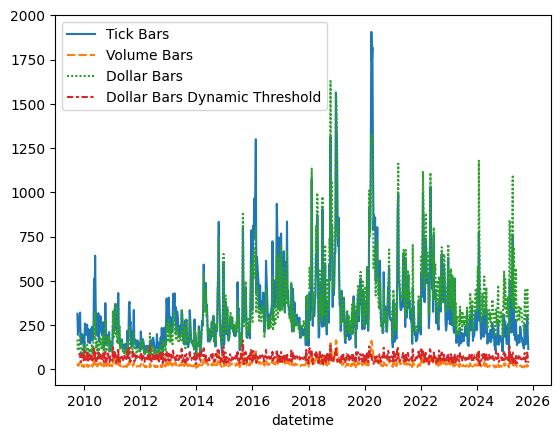

In [137]:
plot_data = pd.concat([tick_bars_weekly, volume_bars_weekly, dollar_bars_weekly, dollar_bars_weekly_dyn], axis=1)
plot_data.columns = ['Tick Bars', 'Volume Bars', 'Dollar Bars', 'Dollar Bars Dynamic Threshold']
sns.lineplot(data=plot_data)


In [139]:
dollar_autocorr = np.log(dollar_bars_dynamic_threshold['close']).diff().dropna().autocorr()

In [140]:
print(f"Dollar bars with dynamic threshold autocorrelation: {dollar_autocorr}")

Dollar bars with dynamic threshold autocorrelation: -0.029455035848536478


# Summary: Evolution to Dynamic Dollar Bars

### 1. Problem Diagnosis (Fixed Threshold)
Initial analysis revealed that the standard approach to Dollar Bars using a **fixed threshold** (e.g., $1M) is flawed over the long term for assets with a strong upward trend (like the S&P 500).
* **Problem:** Asset price appreciation (price inflation) caused the fixed monetary threshold to be hit increasingly faster over time.
* **Effect:** The number of bars grew exponentially instead of remaining stable. Fixed Dollar Bars performed worse (CV ~0.65) than Volume Bars (CV ~0.61).

### 2. Solution: Adaptive Threshold
An adaptive mechanism was implemented where the bar size (threshold) updates daily:
$$Threshold_t = \frac{\text{20-day average daily dollar volume}}{N}$$
where $N$ is the target number of bars per day (e.g., 50).

### 3. Experiment Results

| Method | Stability (CV) | Signal Purity (Autocorrelation) |
| :--- | :--- | :--- |
| **Tick Bars** | 0.68 (Low) | -0.47 (Microstructure noise) |
| **Fixed Dollar** | 0.65 (Moderate) | -0.11 (Moderate) |
| **Dynamic Dollar** | **0.30 (High)** | **-0.03 (Near-perfect IID)** |

**Key Findings:**
1.  **Stability:** The dynamic threshold reduced sampling variability by half. The algorithm generates a consistent data stream regardless of market conditions (bull/bear markets or panic).
2.  **Independence:** An autocorrelation of -0.03 indicates that nearly all noise (such as the Bid-Ask bounce) has been eliminated, producing a series close to the statistical ideal (random walk).

### 4. Critical Conclusion: "The Resolution Dilemma"
High stability and large "buckets" (high threshold) carry the risk of masking short-term, violent events (e.g., a Flash Crash lasting 2 minutes could be "swallowed" by a single large bar).

**Solution:**
A new feature must be added to the model: **Bar Duration**.
* Bar formed in 3 hours = Calm market.
* Bar formed in 30 seconds = Panic/High volatility.
This allows the model to recover the time-dynamic information lost when abandoning standard time bars.